In [474]:
import cv2
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from sklearn.metrics import fbeta_score
import glob
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [452]:
def parse_labels(df_train):
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

In [453]:
# Parse labels
inputs_dir = 'inputs'
print("Read inputs from: %s" % inputs_dir)
df_csv = pd.read_csv(os.path.join(inputs_dir, 'train_v2.csv'))

data_dir = os.path.join(inputs_dir, 'train-jpg')
labels, label_map, inv_label_map = parse_labels(df_csv)
subset_size=10
inv_label_map

Read inputs from: inputs


{0: 'slash_burn',
 1: 'clear',
 2: 'blooming',
 3: 'primary',
 4: 'cloudy',
 5: 'conventional_mine',
 6: 'water',
 7: 'haze',
 8: 'cultivation',
 9: 'partly_cloudy',
 10: 'artisinal_mine',
 11: 'habitation',
 12: 'bare_ground',
 13: 'blow_down',
 14: 'agriculture',
 15: 'road',
 16: 'selective_logging'}

In [466]:
X = []
Y = []
np.random.seed(0)
if subset_size is not None:
    df = df_csv.sample(subset_size)
else:
    df = df_csv
data_progress = tqdm(df.values, miniters=1000)
for f, tags in data_progress:
    f_name = '{}.jpg'.format(f)
    img = cv2.imread(os.path.join(data_dir, f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    X.append(img)
#     X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)


100%|██████████| 10/10 [00:00<00:00, 434.83it/s]

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Reshape, Add
from keras.layers import Conv2D, MaxPooling2D, Maximum, Input, AveragePooling2D, LocallyConnected1D, Activation
from keras.layers import Conv2DTranspose, UpSampling2D, GlobalMaxPooling2D
from keras.initializers import glorot_normal, he_normal, orthogonal

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=2, input_shape=(256,256,3)))
model.add(Conv2D(64, (2, 2), strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(17, activation='relu'))
model.add(Dense(17, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [462]:
data_split_seed = 0
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=data_split_seed)

0


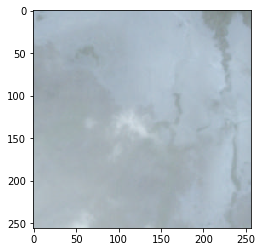

1


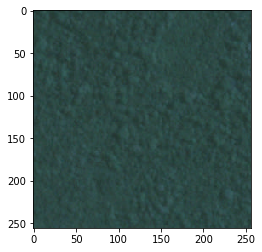

2


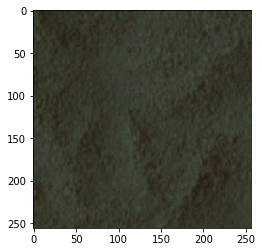

3


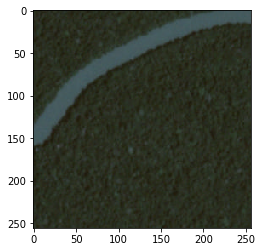

4


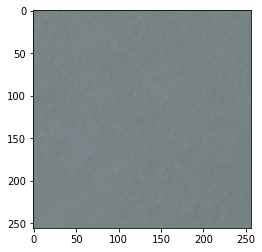

5


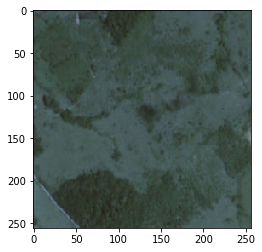

6


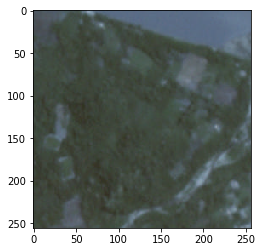

7


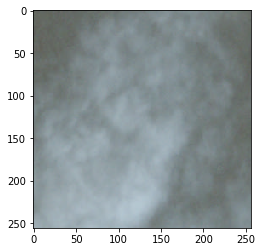

In [484]:
counter=0
for data in X_train:
    print(counter)
    counter+=1
    plt.imshow((255*data).astype(np.uint8))
    plt.show()

In [467]:
df.head(10)

image_name                                               tags
5603    train_5603                      clear habitation primary road
33842  train_33842            agriculture partly_cloudy primary water
20450  train_20450  bare_ground habitation partly_cloudy primary road
25679  train_25679                           clear primary road water
10507  train_10507  agriculture clear cultivation cultivation habi...
32802  train_32802                                             cloudy
17615  train_17615                                             cloudy
13234  train_13234                             blooming clear primary
19933  train_19933                              partly_cloudy primary
21245  train_21245                                      clear primary

In [66]:
Data = np.array([X[1], X[2], X[6], X[7]])

0


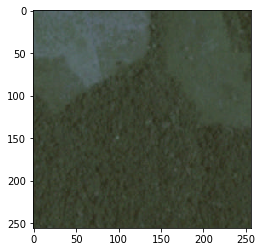

1


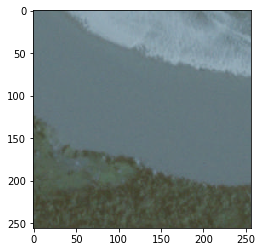

2


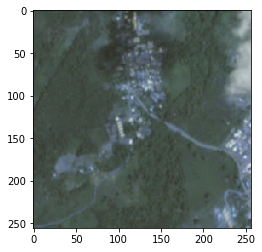

3


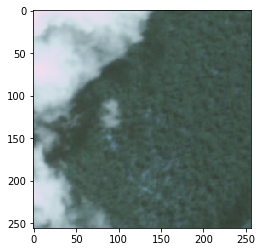

In [112]:
counter=0
for data in Data:
    print(counter)
    counter+=1
    plt.imshow((255*data).astype(np.uint8))
    plt.show()

In [395]:
import random
def randomTranspose(img, u=0.5):
    if random.random() < u:
        img = img.transpose(1,0,2)  #cv2.transpose(img)
    return img

In [376]:
datagen = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function = randomTranspose,
    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(Data, seed=0)

In [341]:
def calc_desc(img):
    a1 = int(img[0,:,0].sum())
    a2 = int(img[:,0,0].sum())
    a3 = int(img[0,0,:].sum() + img[0,-1,:].sum())
    return (a1 - a2)*a3

desc = []
for d in Data:
    desc.append(calc_desc(d))
desc

[10, 74, 6, -105]

In [380]:
augmentation_multiplier = 4
counter=0
augmented = 0
for x_batch, y_batch in datagen.flow(Data, Y_train, batch_size=4, seed=0):
    for data in x_batch:
#         print(counter)
        dsc = calc_desc(data)
#         print("%d: descriptor %d" % (counter, dsc))
        if dsc not in desc:
            augmented+=1
        counter+=1
#         plt.imshow((255*data).astype(np.uint8))
#         plt.show() 
    if counter >= augmentation_multiplier*len(Data):
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
print("Augmentation rate: %f%%" % (100*augmented/(counter+1)))

Augmentation rate: 94.117647%


In [485]:
def data_augmentation(x_data, Y_data, augmentation_multiplier = 4):
    import random
    def randomTranspose(img, u=0.5):
        if random.random() < u:
            img = img.transpose(1,0,2)  #cv2.transpose(img)
        return img

    batch_size = 128 if len(x_data) > 128 else min(4,len(x_data))
    augmented_data_size = augmentation_multiplier * len(x_data)
    X_augmented_shape = (augmented_data_size, x_data.shape[1], x_data.shape[2], x_data.shape[3])
    Y_augmented_shape = (augmented_data_size, Y_data.shape[1])

    X_augmented = np.empty(X_augmented_shape)
    Y_augmented = np.empty(Y_augmented_shape)
    counter=0
    
    datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True, preprocessing_function = randomTranspose)
#     datagen.fit(x_data, seed=0)

    for x_batch, y_batch in datagen.flow(x_data, Y_data, batch_size=batch_size, seed=0):
        X_augmented[counter:counter+batch_size] = x_batch
        Y_augmented[counter:counter+batch_size] = y_batch
        counter+=batch_size
        if counter >= augmented_data_size:
            break
            
    return X_augmented, Y_augmented

In [486]:
data_dir = os.path.join('augmented', 'train_augmented_' + str(augmentation_multiplier) + '_seed_' + str(data_split_seed))
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.makedirs(data_dir)
    
X_train_augmented, Y_train_augmented = data_augmentation(X_train, Y_train)
X_valid_augmented, Y_valid_augmented = data_augmentation(X_valid, Y_valid)

np.save(os.path.join(data_dir, 'X_train_augmented.npy'), X_train_augmented)
np.save(os.path.join(data_dir, 'Y_train_augmented.npy'), Y_train_augmented)
np.save(os.path.join(data_dir, 'X_valid_augmented.npy'), X_valid_augmented)
np.save(os.path.join(data_dir, 'Y_valid_augmented.npy'), Y_valid_augmented)

np.save(os.path.join(data_dir, 'X_train.npy'), X_train)
np.save(os.path.join(data_dir, 'Y_train.npy'), Y_train)
np.save(os.path.join(data_dir, 'X_valid.npy'), X_valid)
np.save(os.path.join(data_dir, 'Y_valid.npy'), Y_valid)

0


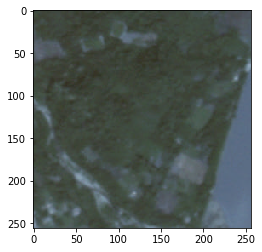

1


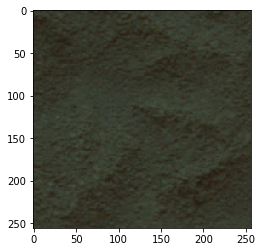

2


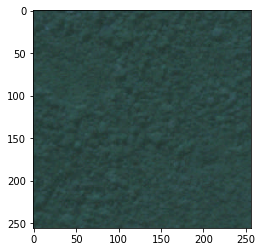

3


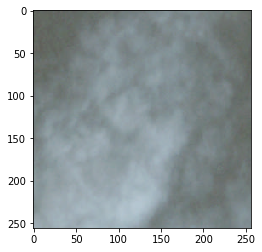

4


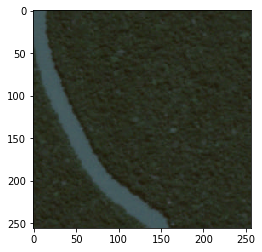

5


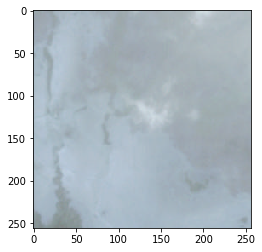

6


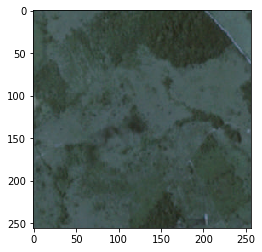

7


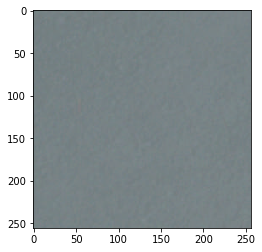

8


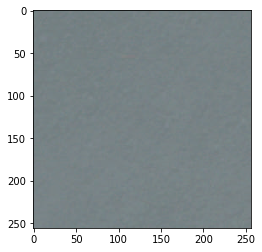

9


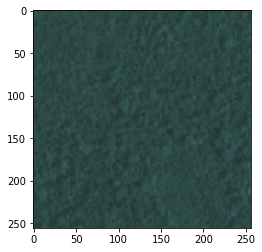

10


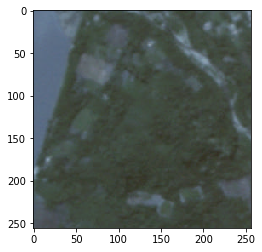

11


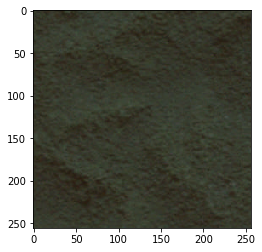

12


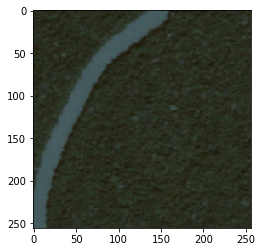

13


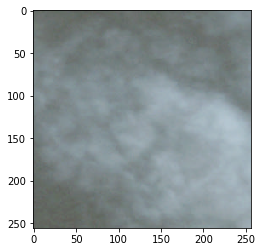

14


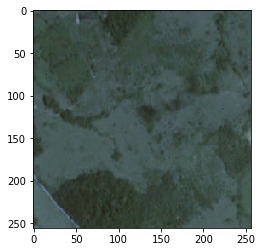

15


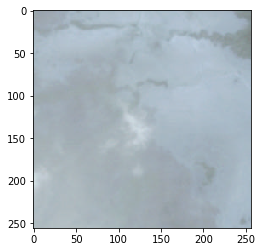

16


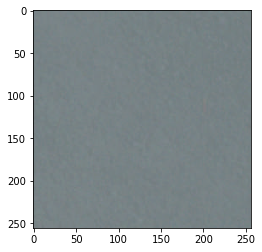

17


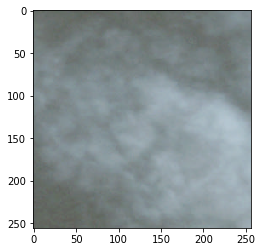

18


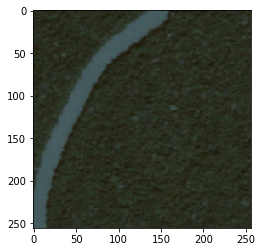

19


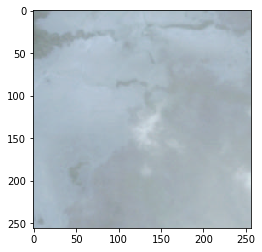

20


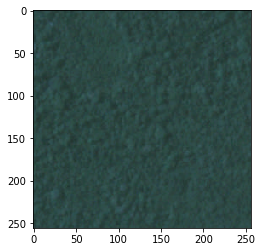

21


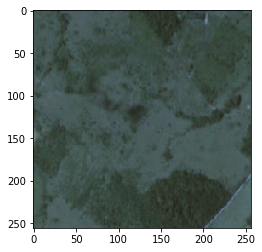

22


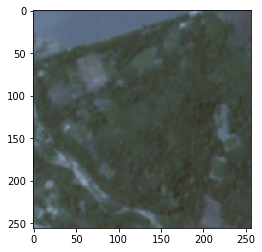

23


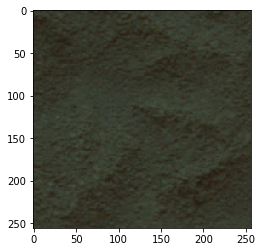

24


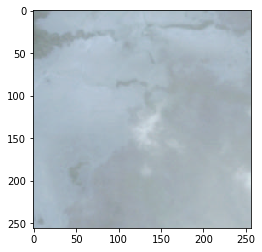

25


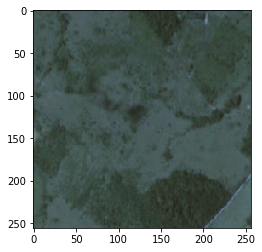

26


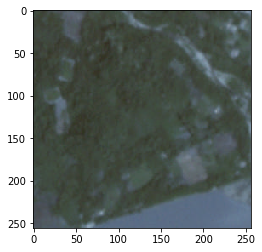

27


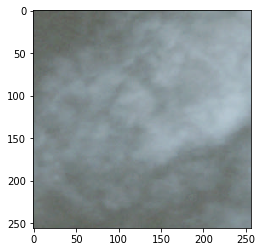

28


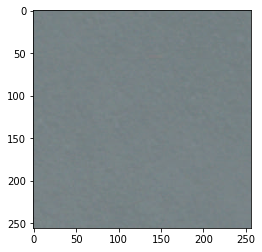

29


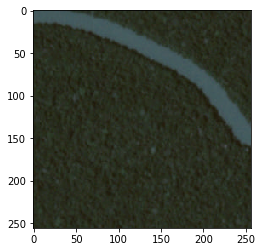

30


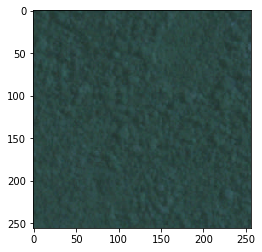

31


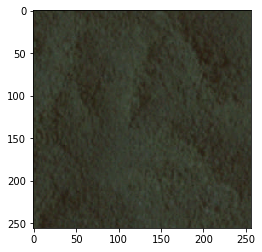

In [483]:
counter=0
for data in X_train_augmented:
    print(counter)
    counter+=1
    plt.imshow((255*data).astype(np.uint8))
    plt.show()

In [415]:
Y_augmented[7].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])